## Autoregressive Model 


An autoregressive model is when a value from a time series is regressed on previous values from that same time series. for example, $y_t$ on $y_{t-1}$

$y_t$ = $\beta_0 + \beta_1y_{t-1} + \epsilon_t$

$y_{t-1}$ - previous value

$\beta_0$ - constant (bias)

$\beta_1$ - coeff 

$\epsilon_t$ - Residual (error term)

!! How many lags we need to keep !! - Depending on our task. More lags make models more complex.

Note: we use Auto-correlation, and Partial Autocorrelation to determine the number of lags.

#### Determining the number of Lags using ACF and PACF


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

##### Primary preprocessing 

In [2]:
raw_csv_data = pd.read_csv("./../datasets/Index2018.csv") 
df=raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index("date", inplace=True)
df=df.asfreq('b')
df=df.fillna(method='ffill')

In [3]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
# picking market value for FTSE 
df['market_value'] = df.ftse

df.drop(["spx","ftse", "nikkei","dax"], axis=1, inplace=True)
df.describe()

,market_value
count,6277.000000
mean,5423.679824
std,1145.616719
min,2876.600000
25%,4486.730000
50%,5663.300000
75%,6304.630175
max,7778.637689


#### Split the data

In [5]:
train_locs = int(df.shape[0]*0.8)
train_locs

5021

In [6]:
df_train, df_test = df.iloc[:train_locs], df.iloc[train_locs:]
df_train, df_test

(            market_value
 date                    
 1994-01-07       3445.98
 1994-01-10       3440.58
 1994-01-11       3413.77
 1994-01-12       3372.02
 1994-01-13       3360.01
 ...                  ...
 2013-04-01       6411.74
 2013-04-02       6490.66
 2013-04-03       6420.28
 2013-04-04       6344.11
 2013-04-05       6249.77
 
 [5021 rows x 1 columns],
             market_value
 date                    
 2013-04-08   6276.940000
 2013-04-09   6313.200000
 2013-04-10   6387.370000
 2013-04-11   6416.140000
 2013-04-12   6384.390000
 ...                  ...
 2018-01-23   7731.827774
 2018-01-24   7643.428966
 2018-01-25   7615.839954
 2018-01-26   7665.541292
 2018-01-29   7671.533300
 
 [1256 rows x 1 columns])

#### ACF

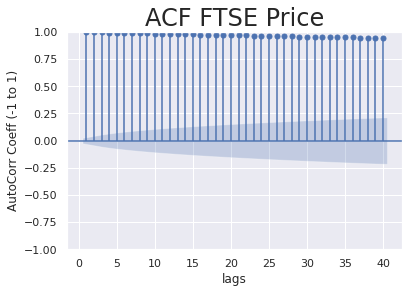

In [7]:
sgt.plot_acf(df.market_value, lags=40, zero=False) 
plt.title("ACF FTSE Price", size=24)
plt.ylabel("AutoCorr Coeff (-1 to 1)")
plt.xlabel("lags")
plt.show()

#### PACF

/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


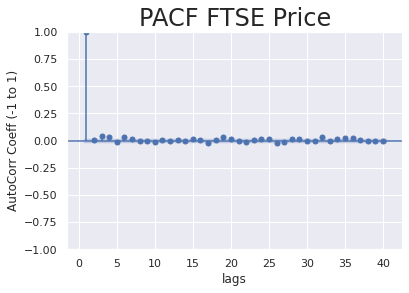

In [8]:
sgt.plot_pacf(df.market_value, lags=40, zero=False) 
plt.title("PACF FTSE Price", size=24)
plt.ylabel("AutoCorr Coeff (-1 to 1)")
plt.xlabel("lags")
plt.show()

Looking at the both graph, we have coefficients that are not significant. The ACF all 40 lag values have ACF coefficient between 0.9 -1, but the PACF coefficients are different. There are some negatively correlated values too. In PACF graph, lags later than 20 are insignificant. Hence, we can conclude 20 lags for our AR model. 

#### AR (1) Model 

Autoregressive model with 1 lag.

In [9]:
ar_model = ARIMA(df.market_value, order=(1,1,1))

In [10]:
ar_results = ar_model.fit()

/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [11]:
ar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6277
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -34418.309
Date:                Tue, 16 Aug 2022   AIC                          68842.619
Time:                        19:58:04   BIC                          68862.852
Sample:                    01-07-1994   HQIC                         68849.630
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8292      0.042     19.904      0.000       0.748       0.911
ma.L1         -0.8641      0.037    -23.249      0.000      -0.937      -0.791
sigma2      3396.1057     36.186     93.850      0.000    3325.181    3467.030
===================================================================================
Ljung-Box (L1) (Q):                   2.84   Jarque-Bera (JB):              3731.72
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.32
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Lets put the summary into AR equation
$y_t$ = $\beta_0 + \beta_1y_{t-1} + \epsilon_t$

looking at the ARIMA Model summary. 

$\beta_0$ = 5423.6789

$\beta_2$ = 0.9988 (Can match with ACF graph too)

$\epsilon_t$ = 0.001

$Z$ - z statistics 

$P>|z|$ - p-value, we have 0.00, and safe to conclude the $\beta_0$ and $\beta_1$ are significantly different than zero.

[0.025  0.975] - Gives us the 90% confidence interval. Since, zero is not part if it, hence we can conclude that the coefficients are significant. 

#### Going Higher with Lag values 

We are going to check AR(2) ... AR(N) models, and use Log-Likelihood ratio test to examine the models performance based on Lag values.

#### AR(2) Model

In [12]:
ar2_model = ARIMA(df.market_value, order=(2,1,1))
ar2_results = ar2_model.fit()
ar2_results.summary()

/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6277
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -34414.111
Date:                Tue, 16 Aug 2022   AIC                          68836.221
Time:                        19:58:04   BIC                          68863.199
Sample:                    01-07-1994   HQIC                         68845.569
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6765      0.064     10.557      0.000       0.551       0.802
ar.L2         -0.0456      0.010     -4.625      0.000      -0.065      -0.026
ma.L1         -0.6897      0.063    -10.986      0.000      -0.813      -0.567
sigma2      3395.8961     36.197     93.817      0.000    3324.951    3466.841
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3671.91
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.31
Prob(H) (two-sided):                  0.17   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

According to stats, $t-2$ has huge impact rather than $t-1$ lag. $t-1$ is insignificant, looking at $\rho$-value Lets, explore further.

In [13]:
ar3_model = ARIMA(df.market_value, order=(3,0,1))
ar3_results = ar3_model.fit()
ar3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 6277
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -34422.142
Date:                Tue, 16 Aug 2022   AIC                          68856.284
Time:                        19:58:07   BIC                          68896.752
Sample:                    01-07-1994   HQIC                         68870.305
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5423.6871    758.231      7.153      0.000    3937.583    6909.792
ar.L1          1.6688      0.067     24.990      0.000       1.538       1.800
ar.L2         -0.7148      0.063    -11.260      0.000      -0.839      -0.590
ar.L3          0.0458      0.010      4.653      0.000       0.026       0.065
ma.L1         -0.6822      0.066    -10.408      0.000      -0.811      -0.554
sigma2      3390.7695     36.395     93.165      0.000    3319.436    3462.103
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3653.41
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.30
Prob(H) (two-sided):                  0.17   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### LLR (Log-Likelihood) Test 

In [14]:
def llr_test(model_one, model_two, df=1):
    l1 = model_one.fit().llf
    l2 = model_two.fit().llf
    lr = (2*(l2-l1))
    p = chi2.sf(lr, df).round(3)
    return p

Comparing the models

In [15]:
llr_test(ar_model, ar2_model)

/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.

0.004

In [16]:
llr_test(ar2_model, ar3_model)

/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1.0

In [17]:
llr_test(ar_model, ar3_model)

/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tsuyog/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1.0

Looking at the LLR test. we can say that higher the lag values, better is the prediction. We can continue until a point where p-values is > 0.5.

## Caution

We have assumed that the data is from stationary process, what if not !! Does AR works as expected !! Lets examine 

##### The DF-test 

In [18]:
sts.adfuller(df.market_value)

(-1.597778892117984,
 0.48470912054659715,
 6,
 6270,
 {'1%': -3.4313933778649943,
  '5%': -2.862001080749219,
  '10%': -2.567015430304048},
 68476.87620974617)

We can see the ADF value, which tells us the data is not stationary. 

**What can we do about it ?**

To tackle this challenge, we will transform the data. We will use  **Return** - *The percentage change between two values for two consecutive periods.* 

$
Return = \frac{P_1 - P_{t-1}}{P_{t-1}} *100
$

We have pandas builtin function for it.


In [19]:
df['returns'] = df.market_value.pct_change(1).mul(100)

In [20]:
df.returns

date
1994-01-07         NaN
1994-01-10   -0.156704
1994-01-11   -0.779229
1994-01-12   -1.222988
1994-01-13   -0.356166
                ...   
2018-01-23    0.212382
2018-01-24   -1.143311
2018-01-25   -0.360951
2018-01-26    0.652605
2018-01-29    0.078168
Freq: B, Name: returns, Length: 6277, dtype: float64

We have one NaN value due to return compute. Because, first index value has no previous value to compare with. Hence we drop the instance, since it is just a single data example.

In [21]:
df = df[1:]
df.returns

date
1994-01-10   -0.156704
1994-01-11   -0.779229
1994-01-12   -1.222988
1994-01-13   -0.356166
1994-01-14    1.206842
                ...   
2018-01-23    0.212382
2018-01-24   -1.143311
2018-01-25   -0.360951
2018-01-26    0.652605
2018-01-29    0.078168
Freq: B, Name: returns, Length: 6276, dtype: float64

Lets just verify that we have returns data source is stationary.

In [22]:
sts.adfuller(df.returns)

(-15.140761332034819,
 7.016338451093803e-28,
 34,
 6241,
 {'1%': -3.431398228116075,
  '5%': -2.8620032237533897,
  '10%': -2.5670165710764503},
 19026.504469066465)

Looking at the ADF test scores, we can conclude that data is stationary looking at critical value, $\rho$-value, and lag.

#### Let Examine the ACF and PACF for Returns 

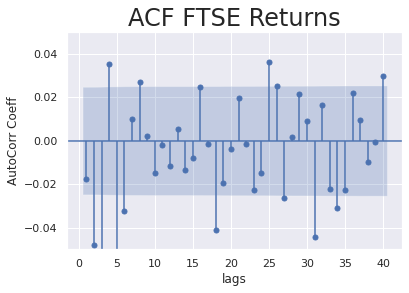

In [23]:
sgt.plot_acf(df.returns, lags=40, zero=False) 
plt.title("ACF FTSE Returns", size=24)
plt.ylabel("AutoCorr Coeff")
plt.ylim(-0.05, 0.05)
plt.xlabel("lags")
plt.show()

We see a different result than FTSE price. The magnitude is changed, and half of the points have negative correlation.

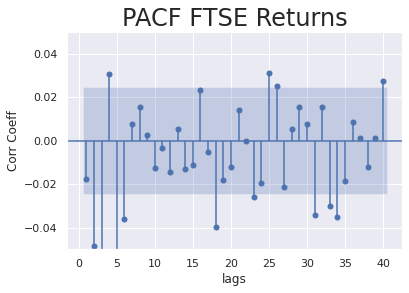

In [24]:
sgt.plot_pacf(df.returns, lags=40, zero=False, method=('ols')) 
plt.title("PACF FTSE Returns", size=24)
plt.ylabel("Corr Coeff")
plt.ylim(-0.05, 0.05)
plt.xlabel("lags")
plt.show()

Similarly, we have same results from PACF graph. Combining both (ACF, and PACF) graph, 5 of the first 6 coefficients are significant, and 4 of them are negative, which suggests the market is trying to adjust. For instance, If the price was decreased previously, then it will be increased today. *if you have notice during the AR(1), and AR(2) model build, we have the same effect present*. It is a cyclical change. As we move further back the less coefficient value will be.

## AR(1) !! Again

In [25]:
ar_ret_model = ARIMA(df.returns, order=(1,1,1))
ar_ret_result = ar_ret_model.fit()

In [26]:
ar_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9601.065
Date:                Tue, 16 Aug 2022   AIC                          19208.131
Time:                        19:58:15   BIC                          19228.364
Sample:                    01-10-1994   HQIC                         19215.141
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0174      0.008     -2.301      0.021      -0.032      -0.003
ma.L1         -1.0000      0.018    -55.502      0.000      -1.035      -0.965
sigma2         1.2471      0.025     49.697      0.000       1.198       1.296
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10520.05
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
ar_ret_model_2 = ARIMA(df.returns, order=(2,1,1))
ar_ret_result_2 = ar_ret_model_2.fit()
ar_ret_result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9593.719
Date:                Tue, 16 Aug 2022   AIC                          19195.438
Time:                        19:58:16   BIC                          19222.415
Sample:                    01-10-1994   HQIC                         19204.785
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0183      0.008     -2.394      0.017      -0.033      -0.003
ar.L2         -0.0484      0.007     -6.937      0.000      -0.062      -0.035
ma.L1         -1.0000      0.012    -80.592      0.000      -1.024      -0.976
sigma2         1.2442      0.019     65.897      0.000       1.207       1.281
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             10345.40
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
ar_ret_model_3 = ARIMA(df.returns, order=(3,1,1))
ar_ret_result_3 = ar_ret_model_3.fit()
ar_ret_result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -9579.428
Date:                Tue, 16 Aug 2022   AIC                          19168.855
Time:                        20:01:15   BIC                          19202.577
Sample:                    01-10-1994   HQIC                         19180.539
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0215      0.008     -2.761      0.006      -0.037      -0.006
ar.L2         -0.0497      0.007     -7.164      0.000      -0.063      -0.036
ar.L3         -0.0674      0.007     -9.330      0.000      -0.082      -0.053
ma.L1         -1.0000      0.022    -44.753      0.000      -1.044      -0.956
sigma2         1.2385      0.029     43.008      0.000       1.182       1.295
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              9361.83
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
ar_ret_model_4 = ARIMA(df.returns, order=(4,1,1))
ar_ret_result_4 = ar_ret_model_4.fit()
ar_ret_result_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -9576.462
Date:                Tue, 16 Aug 2022   AIC                          19164.924
Time:                        19:58:18   BIC                          19205.390
Sample:                    01-10-1994   HQIC                         19178.945
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0195      0.008     -2.495      0.013      -0.035      -0.004
ar.L2         -0.0481      0.007     -6.902      0.000      -0.062      -0.034
ar.L3         -0.0667      0.007     -9.201      0.000      -0.081      -0.053
ar.L4          0.0307      0.007      4.237      0.000       0.017       0.045
ma.L1         -1.0000      0.015    -66.653      0.000      -1.029      -0.971
sigma2         1.2373      0.021     58.760      0.000       1.196       1.279
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              9090.94
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
llr_test(ar_ret_model, ar_ret_model_2)

0.0

In [31]:
llr_test(ar_ret_model_2, ar_ret_model_3)

0.0

Here, Looking at the Log-likelihood, information criteria like AIC, BIC, and HQIC. It is better to have more lag values. But lets do one more test.

In [32]:
ar_ret_model_6 = ARIMA(df.returns, order=(6,1,1))
ar_ret_result_6 = ar_ret_model_6.fit()
ar_ret_result_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -9562.005
Date:                Tue, 16 Aug 2022   AIC                          19140.009
Time:                        20:05:38   BIC                          19193.964
Sample:                    01-10-1994   HQIC                         19158.704
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0198      0.008     -2.430      0.015      -0.036      -0.004
ar.L2         -0.0509      0.007     -7.154      0.000      -0.065      -0.037
ar.L3         -0.0720      0.007     -9.943      0.000      -0.086      -0.058
ar.L4          0.0277      0.007      3.795      0.000       0.013       0.042
ar.L5         -0.0582      0.007     -8.130      0.000      -0.072      -0.044
ar.L6         -0.0359      0.008     -4.546      0.000      -0.051      -0.020
ma.L1         -1.0000      0.010    -99.940      0.000      -1.020      -0.980
sigma2         1.2316      0.016     77.146      0.000       1.200       1.263
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8884.34
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
ar_ret_model_7 = ARIMA(df.returns, order=(7,1,1))
ar_ret_result_7 = ar_ret_model_7.fit()
ar_ret_result_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -9561.812
Date:                Tue, 16 Aug 2022   AIC                          19141.625
Time:                        20:05:58   BIC                          19202.324
Sample:                    01-10-1994   HQIC                         19162.656
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0195      0.008     -2.393      0.017      -0.036      -0.004
ar.L2         -0.0504      0.007     -7.033      0.000      -0.064      -0.036
ar.L3         -0.0722      0.007     -9.875      0.000      -0.087      -0.058
ar.L4          0.0283      0.007      3.827      0.000       0.014       0.043
ar.L5         -0.0578      0.007     -8.030      0.000      -0.072      -0.044
ar.L6         -0.0357      0.008     -4.520      0.000      -0.051      -0.020
ar.L7          0.0078      0.008      0.977      0.329      -0.008       0.023
ma.L1         -1.0000      0.022    -44.587      0.000      -1.044      -0.956
sigma2         1.2315      0.029     42.601      0.000       1.175       1.288
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8851.76
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
llr_test(ar_ret_model_6, ar_ret_model_7)

0.535

Looking at the LLR (log-Likelihood ratio test), we can say the best leg value is 6 for this model.